### **Experiments**

In [1]:
import sys
sys.path.append('../')
sys.path.append('../nn_survival_analysis')

# define sigmoid function - will be handy later
sigmoid = lambda z : 1 / (1 + np.exp(-z))

In [2]:
from nn_survival_analysis.general_utils import *
from nn_survival_analysis.model_utils import *
from nn_survival_analysis.losses import *
from nn_survival_analysis.models import *
from nn_survival_analysis.other_nn_models import *
from nn_survival_analysis.time_invariant_surv import *
from nn_survival_analysis.time_variant_surv import *
from nn_survival_analysis.traditional_models import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### **Load Data for TIS**

In [3]:
# Read the pickled DataFrames
with open('../05_preprocessing_emr_data/data/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)
# Get configs
with open('../nn_survival_analysis/config.json', "r") as file:
    configs = json.load(file)

### **Testing Time-Invariant Performance**

In [4]:
%%time
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train,
        test_data = x_test, 
        val_data = x_val
)

# fit
tis.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)    

training cluster 0
Epoch 50: Training Loss: 0.0068103, Val Loss: 0.0093310
Epoch 100: Training Loss: 0.0029662, Val Loss: 0.0059174
Epoch 150: Training Loss: -0.0006080, Val Loss: 0.0033945
Epoch 200: Training Loss: 0.0037125, Val Loss: 0.0040350
Epoch 250: Training Loss: 0.0007652, Val Loss: 0.0046049
Epoch 300: Training Loss: 0.0017387, Val Loss: 0.0047962
Epoch 350: Training Loss: -0.0023042, Val Loss: 0.0029638
Epoch 400: Training Loss: 0.0049436, Val Loss: 0.0036828
shapes : (1325, 1325, 1325, 1325)
CPU times: total: 4min 31s
Wall time: 52.7 s


In [5]:
tis_cindex , tis_ibs
# (0.6983104083179899, 0.4106011117042349)
# (0.7002156297076692, 0.40314187686834535)
# (0.6926242824650709, 0.40230030777823067)
# (0.6923436684619398, 0.4076280073466049)
# (0.6982267164223191, 0.40493715743536574)
# (0.6886218406309385, 0.4045050474527682)
# (0.6814967462039045, 0.315929672400816)

(0.6833759590792838, 0.4113274244779206)

In [6]:
tis.explain_with_shap(background_size = 500 , explained_size = 100)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Expected value -5.777766227722168
Subject value -6.5033440589904785


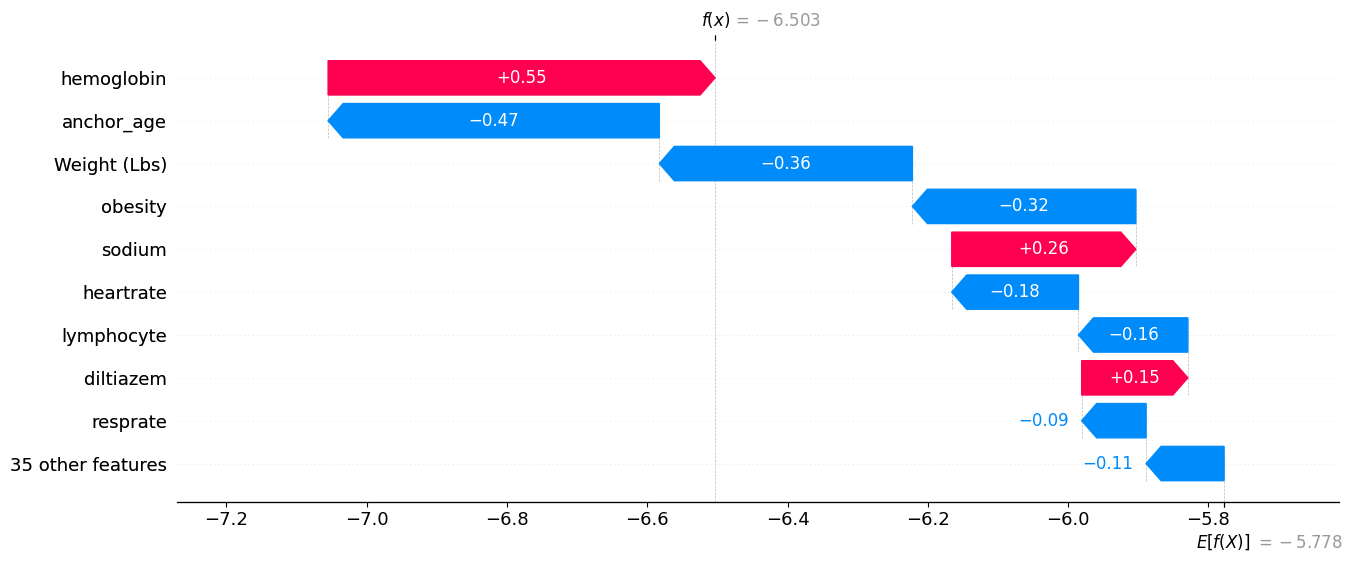

In [7]:
t_s , pat_num = 0 , 0
tis.plot_explain(plot_type = 'waterfall' , t_s = t_s , pat_num = pat_num)

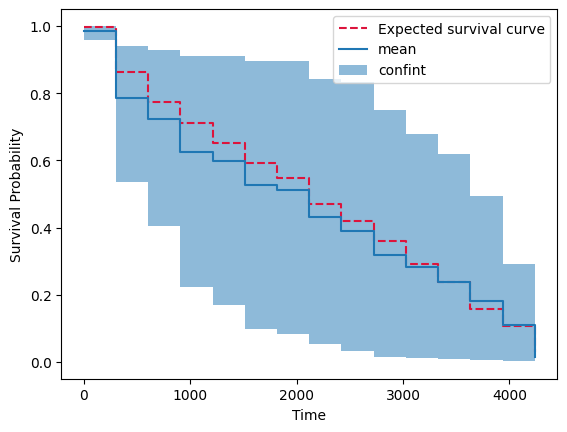

In [11]:
# get death time and event indicator
y_test_dur_ , y_test_event_ = get_target(x_test)

t_test = Transforms(durations = y_test_dur_)
dur_idx_test = t_test.discrete_transform(_cuts = configs['time_invariant']['training']['q_cuts'])

model = tis.nets[0][0]
surv_pat_k = torch.cumprod(1 - torch.sigmoid(model(x_test.iloc[: , :-2].to_numpy())[50 , :]) , dim = 0).detach().numpy()

# Expected survival curve
plt.step(
    t_test.bin_edges , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) , 
    where = 'post' , color = 'crimson' , ls = '--' ,
    label = 'Expected survival curve'
    )

mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict()

# Visualize
tis.visualize(mean_ , up_ , low_ , _from = 10 , _to = 11)
plt.legend()
plt.savefig('diff_exp_curve.pdf' , format = 'pdf')
plt.show()

### **Trying to compare survival curves**

In [12]:
# instantiate - CPH
cph = CPH(configs = configs, train_data = x_train, test_data = x_test, val_data = x_val)

# fit
cph.fit()

In [13]:
cph.eval()

shapes : (1325, 1325, 1325, 1325)


(0.6971421592574499, 0.1623865678248454)

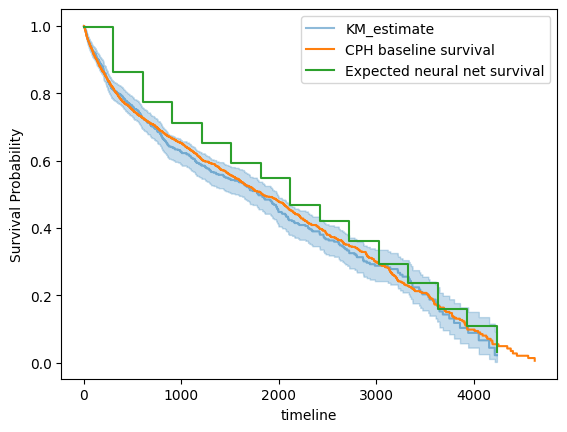

In [14]:
fig , ax = plt.subplots()

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = x_test["time_to_event"]
E = x_test["death"]

kmf.fit(T, event_observed=E)
kmf.plot_survival_function(alpha = 0.5);

# CPH
ax.step((cph.fitter.baseline_survival_).index , (cph.fitter.baseline_survival_)['baseline survival'] , where = 'post' , label = 'CPH baseline survival')

# Expected survival curve
ax.step(t_test.bin_edges , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) , where = 'post' , label = 'Expected neural net survival')
ax.legend()
ax.set_ylabel('Survival Probability');

plt.savefig('comparing_surv_curve.pdf' , format = 'pdf')
plt.show()

#### **Testing Statistical similarity**

In [15]:
import scipy

print(f"KM-NN {scipy.stats.kstest((kmf.survival_function_)['KM_estimate'] , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) )}")
print(f"CPH-NN {scipy.stats.kstest((cph.fitter.baseline_survival_)['baseline survival']  , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) )}")
print(f"KM-CPH {scipy.stats.kstest((cph.fitter.baseline_survival_)['baseline survival']  , (kmf.survival_function_)['KM_estimate'] )}")
print(f"KM-CPH {scipy.stats.kstest((cph.fitter.baseline_survival_)['baseline survival']  , (cph.fitter.baseline_survival_)['baseline survival'])}")

KM-NN KstestResult(statistic=0.2956959706959707, pvalue=0.12371671441948145, statistic_location=0.46921926736831665, statistic_sign=-1)
CPH-NN KstestResult(statistic=0.2632148055728842, pvalue=0.21310070721093144, statistic_location=0.46921926736831665, statistic_sign=-1)
KM-CPH KstestResult(statistic=0.11538461538461539, pvalue=2.878986501078107e-06, statistic_location=0.7375164122950176, statistic_sign=1)
KM-CPH KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.0056733118571078, statistic_sign=1)


### **Load Data for TVS**

In [37]:
# Read the pickled DataFrames
with open('../05_preprocessing_emr_data/data/x_train_reshape_tv.pickle', 'rb') as file:
    x_train_reshape_tv = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_test_reshape_tv.pickle', 'rb') as file:
    x_test_reshape_tv = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_val_reshape_tv.pickle', 'rb') as file:
    x_val_reshape_tv = pickle.load(file)

# Read the pickled targets
with open('../05_preprocessing_emr_data/data/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)
with open('../05_preprocessing_emr_data/data/y_test.pickle', 'rb') as file:
    y_test = pickle.load(file)
with open('../05_preprocessing_emr_data/data/y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)

# Get configs
with open('../nn_survival_analysis/config.json', "r") as file:
    configs = json.load(file)

# configs

### **Testing Time-Variant Performance**

In [18]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Variant Survival
tvs = Time_Variant_Survival(
            configs = configs, 
            x_train_reshape_tv = x_train_reshape_tv,
            x_test_reshape_tv = x_test_reshape_tv, 
            x_val_reshape_tv = x_val_reshape_tv,
            y_train = y_train,
            y_test = y_test,
            y_val = y_val
)

# fit
tvs.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tvs.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tvs_cindex , tvs_ibs = tvs.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

Epoch 50: Training Loss: -0.0119206, Val Loss: 0.0005564
Epoch 100: Training Loss: -0.0066782, Val Loss: 0.0012147
shapes : (1180, 1180, 1180, 1180)


In [19]:
tvs_cindex , tvs_ibs

# (0.7335313759085885, 0.40075786613809444)
# (0.7233037244089423, 0.402674604320726)
# (0.7353032332009801, 0.408018269709824)

(0.7260850445596085, 0.4085434504180699)

### **Trying with different cluster size**

In [28]:
# configs['time_invariant']['training']['clusters'] = 1

In [29]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train,
        test_data = x_test, 
        val_data = x_val
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

shapes : (1060, 1060, 1060, 1060)


In [30]:
tis_cindex , tis_ibs

(0.6887229966307723, 0.4019491137098817)

### **Adding PCA to reduce number of components**

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

In [70]:
# strip of target cols
feed_to_pca = lambda x:x.iloc[: , :-2]

x_train_b4_pca = feed_to_pca(x_train)
x_test_b4_pca = feed_to_pca(x_test)
x_val_b4_pca = feed_to_pca(x_val)

In [71]:
x_train_pca_0 = pd.DataFrame(pca.fit_transform(x_train_b4_pca))
x_test_pca_0 = pd.DataFrame(pca.fit_transform(x_test_b4_pca))
x_val_pca_0 = pd.DataFrame(pca.fit_transform(x_val_b4_pca))

In [72]:
# Check variance captured
np.sum(pca.explained_variance_ratio_)

0.31334215

In [73]:
x_train_pca = pd.concat([x_train_pca_0 , x_train.iloc[: , -2:]] , axis = 1)
x_test_pca = pd.concat([x_test_pca_0 , x_test.iloc[: , -2:]] , axis = 1)
x_val_pca = pd.concat([x_val_pca_0 , x_val.iloc[: , -2:]] , axis = 1)

In [74]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train_pca,
        test_data = x_test_pca, 
        val_data = x_val_pca
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

shapes : (1060, 1060, 1060, 1060)


In [75]:
tis_cindex , tis_ibs

(0.4891259826914184, 0.4147688930722147)

### **PCA & Clustering**

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# strip of target cols
feed_to_pca = lambda x:x.iloc[: , :-2]

x_train_b4_pca = feed_to_pca(x_train)
x_test_b4_pca = feed_to_pca(x_test)
x_val_b4_pca = feed_to_pca(x_val)

x_train_pca_0 = pd.DataFrame(pca.fit_transform(x_train_b4_pca))
x_test_pca_0 = pd.DataFrame(pca.fit_transform(x_test_b4_pca))
x_val_pca_0 = pd.DataFrame(pca.fit_transform(x_val_b4_pca))

# Check variance captured
print(np.sum(pca.explained_variance_ratio_))

x_train_pca = pd.concat([x_train_pca_0 , x_train.iloc[: , -2:]] , axis = 1)
x_test_pca = pd.concat([x_test_pca_0 , x_test.iloc[: , -2:]] , axis = 1)
x_val_pca = pd.concat([x_val_pca_0 , x_val.iloc[: , -2:]] , axis = 1)

# Increase cluster size
configs['time_invariant']['training']['clusters'] = 2

#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train_pca,
        test_data = x_test_pca, 
        val_data = x_val_pca
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

print(tis_cindex , tis_ibs)

0.6008797
shapes : (1060, 1060, 1060, 1060)
0.4986919468851159 0.4150643009153472


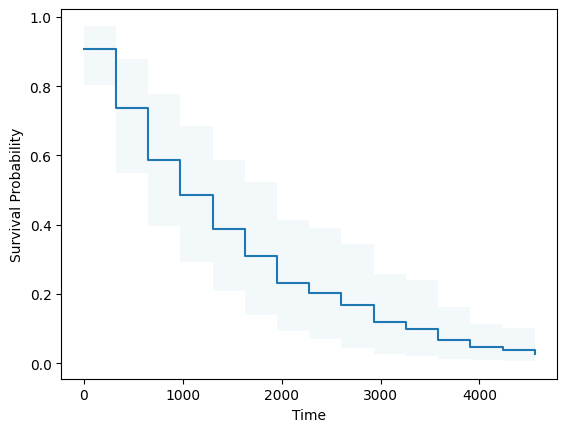

In [5]:
tis.visualize(mean_ , up_ , low_ , _from = 4 , _to = 5 )

### **Experimenting with Other data**

#### **FLCHAIN**

In [4]:
flchain = pd.read_csv("../resources/other_data/FLCHAIN.csv")
flchain.rename(columns = {'futime':'time_to_event'} , inplace = True)

In [5]:
def train_test_splitter(df , test_size = 0.2 , val_size = 0.25 , duration_col = 'futime' , event_col = 'death'):
    df_test = df.sample(frac=test_size)
    df_train = df.drop(df_test.index)

    df_val = df_train.sample(frac=val_size)
    df_train = df_train.drop(df_val.index)

    return df_train , df_val , df_test

In [6]:
# Create an instance of the OneHotEncoder class
encoder1 = LabelEncoder()
encoder2 = LabelEncoder()

# Fit and transform the data
encoded_sex_data = encoder1.fit_transform(flchain['sex'])
encoded_sex_data = pd.DataFrame(encoded_sex_data.reshape(-1 , 1) , columns = ['sex']) 
print(f'encoded_sex_data.shape {encoded_sex_data.shape}')

# Fit and transform the data
encoded_chap_data = encoder2.fit_transform(flchain['chapter'])
encoded_chap_data = pd.DataFrame(encoded_chap_data.reshape(-1 , 1) , columns = ['chapter'])
print(f'encoded_chap_data.shape {encoded_chap_data.shape}')

flchain_mod = pd.DataFrame(
    pd.concat(
        [
            encoded_sex_data , 
            encoded_chap_data , 
            flchain[['age' , 'sample.yr' , 'kappa' , 'lambda' , 'flc.grp' , 'creatinine' , 'mgus']] , 
            flchain[['time_to_event' , 'death']]
        ] ,
        axis = 1
        )
    )

print(f'flchain_mod.shape {flchain_mod.shape}')

encoded_sex_data.shape (7874, 1)
encoded_chap_data.shape (7874, 1)
flchain_mod.shape (7874, 11)


In [7]:
def impute(df):
    _imputer = SimpleImputer(strategy='mean')
    df_imp = pd.DataFrame(_imputer.fit_transform(df) , columns = df.columns)
    return df_imp

def scale(df):
    _scaler = StandardScaler()
    scale_cols = ['age' , 'sample.yr' , 'kappa' , 'lambda' , 'flc.grp' , 'creatinine' , 'mgus']
    unscaled_cols = [col for col in df.columns if col not in scale_cols]
    scaled = pd.DataFrame(_scaler.fit_transform(df[scale_cols]) , columns = scale_cols)
    return pd.concat([scaled , df[unscaled_cols]] , axis = 1)

In [8]:
df_train , df_test , df_val = train_test_splitter(flchain_mod)
preprocess = lambda df: scale(impute(df))
# preprocess train
df_train_ppcss = preprocess(df_train)

# preprocess test
df_test_ppcss = preprocess(df_test)

# preprocess val
df_val_ppcss = preprocess(df_val)

In [9]:
%%time
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = df_train_ppcss,
        test_data = df_test_ppcss, 
        val_data = df_val_ppcss
)

# fit
tis.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)    

training cluster 0
Epoch 50: Training Loss: -0.2935149, Val Loss: -0.2717924
Epoch 100: Training Loss: -0.2741421, Val Loss: -0.2815606
Epoch 150: Training Loss: -0.3594517, Val Loss: -0.3171348
Epoch 200: Training Loss: -0.3279325, Val Loss: -0.3393398
Epoch 250: Training Loss: -0.3541194, Val Loss: -0.3420588
Epoch 300: Training Loss: -0.3421190, Val Loss: -0.3412602
Epoch 350: Training Loss: -0.3303965, Val Loss: -0.3548764
Epoch 400: Training Loss: -0.3814132, Val Loss: -0.3550162
shapes : (1575, 1575, 1575, 1575)
CPU times: total: 7min
Wall time: 1min 37s


In [10]:
tis_cindex , tis_ibs

(0.9221980879712078, 0.10481763329677724)

0:	[0s / 0s],		train_loss: 5.2797,	val_loss: 2.6447
1:	[0s / 0s],		train_loss: 2.2462,	val_loss: 1.0380
2:	[0s / 0s],		train_loss: 1.1183,	val_loss: 1.0431
3:	[0s / 0s],		train_loss: 0.8423,	val_loss: 2.2946
4:	[0s / 0s],		train_loss: 0.7389,	val_loss: 58.6151
5:	[0s / 0s],		train_loss: 0.7314,	val_loss: 0.4803
6:	[0s / 0s],		train_loss: 0.6784,	val_loss: 0.4673
7:	[0s / 0s],		train_loss: 0.6972,	val_loss: 1.9028
8:	[0s / 0s],		train_loss: 0.6591,	val_loss: 1.3106
9:	[0s / 0s],		train_loss: 0.6731,	val_loss: 0.7977
10:	[0s / 0s],		train_loss: 0.6409,	val_loss: 0.4905
11:	[0s / 0s],		train_loss: 0.6201,	val_loss: 0.4804
12:	[0s / 0s],		train_loss: 0.6390,	val_loss: 0.5766
13:	[0s / 0s],		train_loss: 0.6283,	val_loss: 0.5374
14:	[0s / 1s],		train_loss: 0.6005,	val_loss: 0.4448
15:	[0s / 1s],		train_loss: 0.5826,	val_loss: 0.6543
16:	[0s / 1s],		train_loss: 0.5931,	val_loss: 0.6887
17:	[0s / 1s],		train_loss: 0.5799,	val_loss: 0.4380
18:	[0s / 1s],		train_loss: 0.5814,	val_loss: 0.3832
19

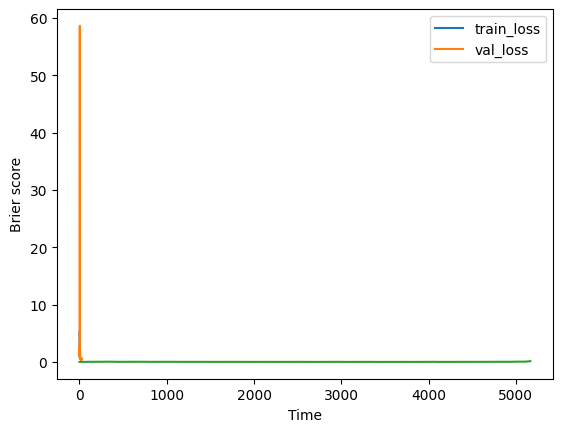

In [15]:
# PyCox

num_durations = 15

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['time_to_event'].values, df['death'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (df_train_ppcss.to_numpy().astype('float32'), y_train)
val = (df_val_ppcss.to_numpy().astype('float32'), y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test_ppcss)

in_features = df_train_ppcss.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.5

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 400
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(df_train_ppcss.to_numpy().astype('float32'), y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

surv = model.predict_surv_df(df_test_ppcss.to_numpy().astype('float32'))

from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **METABRIC**

In [1]:
from pycox.datasets import metabric
from sklearn_pandas import DataFrameMapper 

import sys
sys.path.append('../')
sys.path.append('../nn_survival_analysis')

# define sigmoid function - will be handy later
sigmoid = lambda z : 1 / (1 + np.exp(-z))

from nn_survival_analysis.general_utils import *
from nn_survival_analysis.model_utils import *
from nn_survival_analysis.losses import *
from nn_survival_analysis.models import *
from nn_survival_analysis.other_nn_models import *
from nn_survival_analysis.time_invariant_surv import *
from nn_survival_analysis.time_variant_surv import *
from nn_survival_analysis.traditional_models import *

# Get configs
with open('../nn_survival_analysis/config.json', "r") as file:
    configs = json.load(file)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def train_test_splitter(df , test_size = 0.2 , val_size = 0.25 , duration_col = 'futime' , event_col = 'death'):
    df_test = df.sample(frac=test_size)
    df_train = df.drop(df_test.index)

    df_val = df_train.sample(frac=val_size)
    df_train = df_train.drop(df_val.index)

    return df_train , df_val , df_test

In [3]:
df = metabric.read_df()
df_train , df_test , df_val = train_test_splitter(df)

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train_dur , y_train_event = get_target(df_train)
y_test_dur , y_test_event = get_target(df_test)
y_val_dur , y_val_event = get_target(df_val)

0:	[0s / 0s],		train_loss: 4.3293,	val_loss: 3.9325
1:	[0s / 0s],		train_loss: 3.9525,	val_loss: 3.6055
2:	[0s / 0s],		train_loss: 3.6108,	val_loss: 3.2323
3:	[0s / 0s],		train_loss: 3.2485,	val_loss: 2.7750
4:	[0s / 0s],		train_loss: 2.8137,	val_loss: 2.3371
5:	[0s / 0s],		train_loss: 2.4383,	val_loss: 1.9953
6:	[0s / 0s],		train_loss: 2.1360,	val_loss: 1.7941
7:	[0s / 0s],		train_loss: 1.9463,	val_loss: 1.7101
8:	[0s / 0s],		train_loss: 1.8626,	val_loss: 1.6978
9:	[0s / 0s],		train_loss: 1.8208,	val_loss: 1.6969
10:	[0s / 0s],		train_loss: 1.8354,	val_loss: 1.6914
11:	[0s / 0s],		train_loss: 1.7730,	val_loss: 1.6790
12:	[0s / 0s],		train_loss: 1.7671,	val_loss: 1.6685
13:	[0s / 0s],		train_loss: 1.7317,	val_loss: 1.6590
14:	[0s / 0s],		train_loss: 1.7406,	val_loss: 1.6517
15:	[0s / 0s],		train_loss: 1.7350,	val_loss: 1.6501
16:	[0s / 0s],		train_loss: 1.7341,	val_loss: 1.6465
17:	[0s / 0s],		train_loss: 1.7250,	val_loss: 1.6440
18:	[0s / 0s],		train_loss: 1.7298,	val_loss: 1.6475
19:

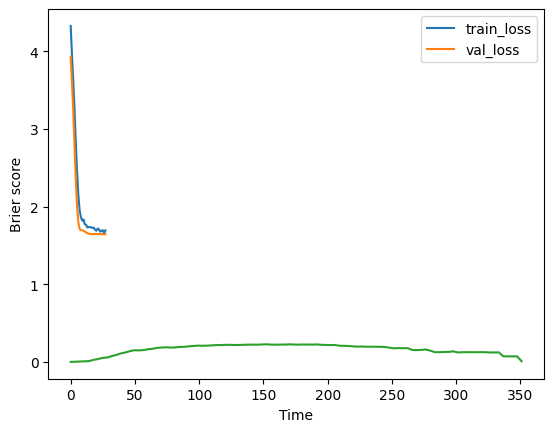

In [10]:
num_durations = 15

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.5

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 800
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

surv = model.predict_surv_df(x_test)

from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

In [5]:
x_train = pd.DataFrame(x_mapper.fit_transform(df_train).astype('float32') , columns = df_train.iloc[: , :-2].columns)
x_val = pd.DataFrame(x_mapper.transform(df_val).astype('float32') , columns = df_val.iloc[: , :-2].columns)
x_test = pd.DataFrame(x_mapper.transform(df_test).astype('float32') , columns = df_test.iloc[: , :-2].columns)

x_train = pd.concat([x_train , df_train[['duration' , 'event']].reset_index().drop('index' , axis = 1)] , axis = 1)
x_test = pd.concat([x_test , df_test[['duration' , 'event']].reset_index().drop('index' , axis = 1)] , axis = 1)
x_val = pd.concat([x_val , df_val[['duration' , 'event']].reset_index().drop('index' , axis = 1)] , axis = 1)

x_train.rename(columns = {'duration':'time_to_event' , 'event': 'death'}, inplace = True)
x_test.rename(columns = {'duration':'time_to_event' , 'event': 'death'}, inplace = True)
x_val.rename(columns = {'duration':'time_to_event' , 'event': 'death'}, inplace = True)

In [11]:
%%time
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train,
        test_data = x_test, 
        val_data = x_val
)

# fit
tis.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)    

training cluster 0
Epoch 50: Training Loss: 0.0015756, Val Loss: 0.0029702
Epoch 100: Training Loss: 0.0039610, Val Loss: -0.0041809
Epoch 150: Training Loss: -0.0184253, Val Loss: 0.0017809
Epoch 200: Training Loss: -0.0071692, Val Loss: -0.0075780
Epoch 250: Training Loss: -0.0146750, Val Loss: -0.0009955
Epoch 300: Training Loss: -0.0134677, Val Loss: -0.0120901
Epoch 350: Training Loss: -0.0121547, Val Loss: -0.0037951
Epoch 400: Training Loss: -0.0180724, Val Loss: 0.0013842
Epoch 450: Training Loss: -0.0210772, Val Loss: 0.0029824
Epoch 500: Training Loss: -0.0101194, Val Loss: -0.0065835
Epoch 550: Training Loss: -0.0115780, Val Loss: -0.0030381
Epoch 600: Training Loss: -0.0086235, Val Loss: -0.0034233
Epoch 650: Training Loss: -0.0131769, Val Loss: -0.0038520
Epoch 700: Training Loss: -0.0153295, Val Loss: -0.0056207
Epoch 750: Training Loss: -0.0156763, Val Loss: -0.0067977
Epoch 800: Training Loss: -0.0178084, Val Loss: -0.0095012
shapes : (381, 381, 381, 381)
CPU times: tot

In [12]:
tis_cindex , tis_ibs
# (0.6757361460705582, 0.39687120671330284)
# (0.6123928010629303, 0.4049915863092185)
# (0.6161774771510247, 0.4028830738458925)
# (0.6264784973412322, 0.41911247705659666)

(0.6222932125598981, 0.4077907067807754)

In [6]:
# instantiate - RSF
rsf = RSF(configs = configs, train_data = x_train, test_data = x_test, val_data = x_val)

# fit
rsf.fit()
# eval
rsf_cindex , rsf_ibs = rsf.eval(fitter_is_rsf = True)

shapes : (381, 381, 381, 381)


In [7]:
rsf_cindex , rsf_ibs 

(0.6448259823252239, 0.15966229792148415)

#### **SUPPORT**

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper
from pycox.datasets import support
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

import sys
sys.path.append('../')
sys.path.append('../nn_survival_analysis')

# define sigmoid function - will be handy later
sigmoid = lambda z : 1 / (1 + np.exp(-z))

from nn_survival_analysis.general_utils import *
from nn_survival_analysis.model_utils import *
from nn_survival_analysis.losses import *
from nn_survival_analysis.models import *
from nn_survival_analysis.other_nn_models import *
from nn_survival_analysis.time_invariant_surv import *
from nn_survival_analysis.time_variant_surv import *
from nn_survival_analysis.traditional_models import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1485.)


0:	[0s / 0s],		train_loss: 9.1902,	val_loss: 8.7744
1:	[0s / 0s],		train_loss: 8.9704,	val_loss: 8.5216
2:	[0s / 0s],		train_loss: 8.8142,	val_loss: 8.4997
3:	[0s / 0s],		train_loss: 8.6473,	val_loss: 8.2426
4:	[0s / 0s],		train_loss: 8.4895,	val_loss: 8.0842
5:	[0s / 1s],		train_loss: 8.3444,	val_loss: 8.0219
6:	[0s / 1s],		train_loss: 8.3042,	val_loss: 7.9998
7:	[0s / 1s],		train_loss: 8.2244,	val_loss: 7.7747
8:	[0s / 1s],		train_loss: 8.0081,	val_loss: 7.5238
9:	[0s / 1s],		train_loss: 7.7245,	val_loss: 7.2933
10:	[0s / 1s],		train_loss: 7.5493,	val_loss: 7.0758
11:	[0s / 1s],		train_loss: 7.3837,	val_loss: 6.9396
12:	[0s / 2s],		train_loss: 7.2662,	val_loss: 6.8466
13:	[0s / 2s],		train_loss: 7.2171,	val_loss: 6.8088
14:	[0s / 2s],		train_loss: 7.1851,	val_loss: 6.8237
15:	[0s / 2s],		train_loss: 7.0868,	val_loss: 6.5925
16:	[0s / 2s],		train_loss: 6.8085,	val_loss: 6.2394
17:	[0s / 2s],		train_loss: 6.5235,	val_loss: 5.9980
18:	[0s / 3s],		train_loss: 6.2287,	val_loss: 5.7201
19:

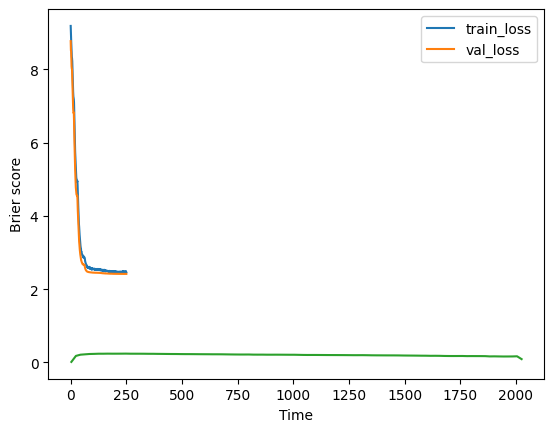

In [3]:
df_train = support.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

num_durations = 20
scheme = 'quantiles'
labtrans = LogisticHazard.label_transform(num_durations, scheme)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)

train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)

batch_size = 256
epochs = 800
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

surv = model.predict_surv_df(x_test)

from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

In [50]:
# Get configs
with open('../nn_survival_analysis/config.json', "r") as file:
    configs = json.load(file)

df_train = support.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper = DataFrameMapper(standardize + leave + categorical)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train_dur , y_train_event = get_target(df_train)
y_test_dur , y_test_event = get_target(df_test)
y_val_dur , y_val_event = get_target(df_val)
print(configs)

{'time_invariant': {'training': {'clusters': 1, 'q_cuts': 15, 'hidden_size': 32, 'alpha': 0.001, 'batch_size': 512, 'num_epochs': 800, 'learning_rate': 0.001, 'shuffle': True, 'patience': 50, 'dropout': 0.5}, 'testing': {'mc_iter': 100, 'conf_int_lower': 0.05, 'conf_int_upper': 0.95}, 'test_viz': {'transparency': 0.5}, 'eval': {'time_grid_div': 100}}, 'time_variant': {'training': {'q_cuts': 15, 'hidden_size': 25, 'alpha': 0.01, 'batch_size': 256, 'num_epochs': 100, 'learning_rate': 0.001, 'shuffle': True, 'patience': 20, 'dropout': 0.5}, 'testing': {'mc_iter': 100, 'conf_int_lower': 0.05, 'conf_int_upper': 0.95}, 'test_viz': {'transparency': 0.05}, 'eval': {'time_grid_div': 100}}}


In [51]:
_df_train = np.concatenate([x_train , y_train_dur.reshape(-1 , 1) , y_train_event.reshape(-1 , 1)] , axis = 1)
_df_test = np.concatenate([x_test , y_test_dur.reshape(-1 , 1) , y_test_event.reshape(-1 , 1)] , axis = 1)
_df_val = np.concatenate([x_val , y_val_dur.reshape(-1 , 1) , y_val_event.reshape(-1 , 1)] , axis = 1)

In [52]:
_df_train = pd.DataFrame(_df_train , columns = df_train.columns)
_df_test = pd.DataFrame(_df_test , columns = df_test.columns)
_df_val = pd.DataFrame(_df_val , columns = df_val.columns)

In [53]:
_df_train.rename(columns = {'duration':'time_to_event' , 'event':'death'} , inplace = True)
_df_test.rename(columns = {'duration':'time_to_event' , 'event':'death'} , inplace = True)
_df_val.rename(columns = {'duration':'time_to_event' , 'event':'death'} , inplace = True)

In [54]:
%%time
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = _df_train,
        test_data = _df_test, 
        val_data = _df_val
)

# fit
tis.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)    

training cluster 0


Epoch 50: Training Loss: -0.0085721, Val Loss: -0.0063926
Epoch 100: Training Loss: -0.0089293, Val Loss: -0.0084198
Epoch 150: Training Loss: -0.0114433, Val Loss: -0.0157116
Epoch 200: Training Loss: -0.0024558, Val Loss: -0.0099544
Epoch 250: Training Loss: -0.0130174, Val Loss: -0.0093867
Epoch 300: Training Loss: -0.0131139, Val Loss: -0.0099270
Epoch 350: Training Loss: -0.0131980, Val Loss: -0.0147984
Epoch 400: Training Loss: -0.0133906, Val Loss: -0.0103633
Epoch 450: Training Loss: -0.0136235, Val Loss: -0.0119598
Epoch 500: Training Loss: -0.0055116, Val Loss: -0.0102178
Epoch 550: Training Loss: -0.0161384, Val Loss: -0.0134004
Epoch 600: Training Loss: -0.0153033, Val Loss: -0.0150618
Epoch 650: Training Loss: -0.0123068, Val Loss: -0.0154753
Epoch 700: Training Loss: -0.0017282, Val Loss: -0.0109226
Epoch 750: Training Loss: -0.0180425, Val Loss: -0.0159916
Epoch 800: Training Loss: -0.0190295, Val Loss: -0.0124057
shapes : (1775, 1775, 1775, 1775)
CPU times: total: 12min

In [55]:
tis_cindex , tis_ibs

(0.5832837251120063, 0.21744437716881787)

In [47]:
# instantiate - CPH
cph = CPH(configs = configs, train_data = _df_train, test_data = _df_test, val_data = _df_val)

# fit
cph.fit()

# eval
cph_cindex , cph_ibs = cph.eval(fitter_is_rsf = False)

shapes : (1775, 1775, 1775, 1775)


In [49]:
cph_cindex , cph_ibs

(0.5714628370602174, 0.20707541946865643)

In [56]:
# instantiate - RSF
rsf = RSF(configs = configs, train_data = _df_train, test_data = _df_test, val_data = _df_val)

# fit
rsf.fit()

# eval
rsf_cindex , rsf_ibs = rsf.eval(fitter_is_rsf = True)

shapes : (1775, 1775, 1775, 1775)


In [57]:
rsf_cindex , rsf_ibs

(0.6353661109938805, 0.18740315819604889)

### **Repeated Fits**

In [6]:
dict_fits = {
    'tvs': {
        'cindex': [0.7224018246208733, 0.7261133169075605, 0.7221847324011446, 0.72514032527215, 0.7178533502822199, 0.7117956926811151, 0.7146205071065007, 0.7262336330775307, 0.7138567609840817, 0.7136841334358637], 
        'ibs': [0.36797406596513416, 0.3709111966353304, 0.36725453870356556, 0.3764632001412606, 0.3721288492190593, 0.3745771862117764, 0.3756849018192498, 0.374173373275104, 0.37839087826975115, 0.36356568826216346]
        }, 
    'tis': {
        'cindex': [0.7017279644895371, 0.692230221194375, 0.697955910328621, 0.7010751986273266, 0.6997230407698907, 0.7027257637360588, 0.705201611399157, 0.7001193629005185, 0.6979512477153195, 0.6960489014883061], 
        'ibs': [0.4223844343072177, 0.4257995374134107, 0.43033377346061574, 0.4246115213138635, 0.42581609832882444, 0.4213766763966916, 0.4266165932120578, 0.4146521131242105, 0.41892248393447906, 0.42437463812629134]
        }, 
    'cph': {
        'cindex': [0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649], 
        'ibs': [0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045]
        }, 
    'aft': {
        'cindex': [0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827], 
        'ibs': [0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768]
        },
    'pyc': {
        'cindex': [0.6398653859636823, 0.6240949776811797, 0.6248568557339503, 0.603701885998738, 0.5846268900885742, 0.6111103320946972, 0.5898712285867863, 0.5766575521746243, 0.6050854191497815, 0.6263946341349412], 
        'ibs': [0.185703217140601, 0.18419431362009342, 0.1885125115023738, 0.1864750508313879, 0.1856505259781314, 0.1846424030364299, 0.18410019939550284, 0.18216953733901187, 0.184741837771625, 0.18328240347492933]
        }, 
    'dsm': {
        'cindex': [0.6625207413120194, 0.6674846339012362, 0.6433662857276403, 0.6659421814017621, 0.674350884573138, 0.664418425296221, 0.6518404262777817, 0.6631938114936081, 0.6632732711678235, 0.6544111804435719], 
        'ibs': [0.2741155868837711, 0.27495346533550025, 0.28558186057445517, 0.2733886385629673, 0.2710429359459442, 0.27603908554515233, 0.27962866451242396, 0.27359101741676467, 0.27266032357716324, 0.2816053583253264]
        },
    'rsf': {
        'cindex': [0.704442730608334, 0.7153287059758349, 0.7098646848489097, 0.7097151136974456, 0.7187501460655776, 0.7098600107504265, 0.7146369394003131, 0.712454135408633, 0.711481922924116, 0.7072939306831195], 
        'ibs': [0.20453408416023894, 0.20231085663928475, 0.20269646114774262, 0.20354918027769564, 0.2031119423550705, 0.2040444977586439, 0.20402816315659664, 0.20207826736985712, 0.20351577867594073, 0.20295164667147228]
        }
    }

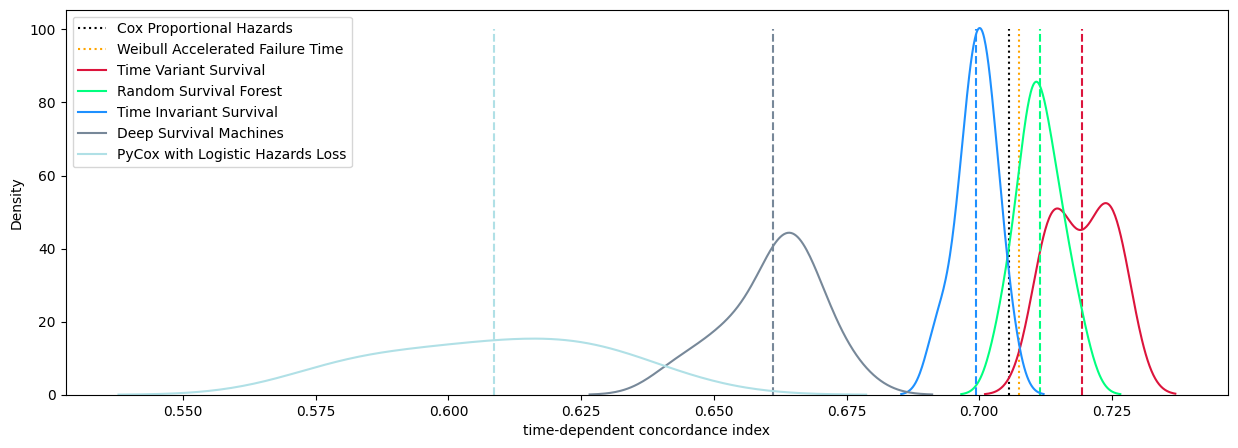

In [9]:
import seaborn as sns

criteria = 'cindex'

fig , ax = plt.subplots(figsize = (15 , 5))

plt.vlines(np.mean(np.array(dict_fits['cph'][criteria])) , ymin = 0 , ymax = 100 , color = 'black' , ls=':' ,
           label = 'Cox Proportional Hazards')
plt.vlines(np.mean(np.array(dict_fits['aft'][criteria])) , ymin = 0 , ymax = 100 , color = 'orange' , ls=':' ,
           label = 'Weibull Accelerated Failure Time')

sns.kdeplot(np.array(dict_fits['tvs'][criteria]) , label = 'Time Variant Survival' , color = 'crimson');
plt.vlines(np.mean(np.array(dict_fits['tvs'][criteria])) , ymin = 0 , ymax = 100 , ls = '--' , color = 'crimson')

sns.kdeplot(np.array(dict_fits['rsf'][criteria]) , label = 'Random Survival Forest' , color = 'springgreen');
plt.vlines(np.mean(np.array(dict_fits['rsf'][criteria])) , ymin = 0 , ymax = 100 , ls = '--' , color = 'springgreen')

sns.kdeplot(np.array(dict_fits['tis'][criteria]) , label = 'Time Invariant Survival' , color = 'dodgerblue');
plt.vlines(np.mean(np.array(dict_fits['tis'][criteria])) , ymin = 0 , ymax = 100 , ls = '--' , color = 'dodgerblue')

sns.kdeplot(np.array(dict_fits['dsm'][criteria]) , label = 'Deep Survival Machines' , color = 'lightslategray');
plt.vlines(np.mean(np.array(dict_fits['dsm'][criteria])) , ymin = 0 , ymax = 100 , ls = '--' , color = 'lightslategray')

sns.kdeplot(np.array(dict_fits['pyc'][criteria]) , label = 'PyCox with Logistic Hazards Loss', color = 'powderblue');
plt.vlines(np.mean(np.array(dict_fits['pyc'][criteria])) , ymin = 0 , ymax = 100 , ls = '--' , color = 'powderblue')
plt.legend(loc='upper left');
plt.xlabel('time-dependent concordance index')

# Save the plot as an SVG file
plt.savefig('cindex_score_dist_plot.pdf', format='pdf')

plt.show()

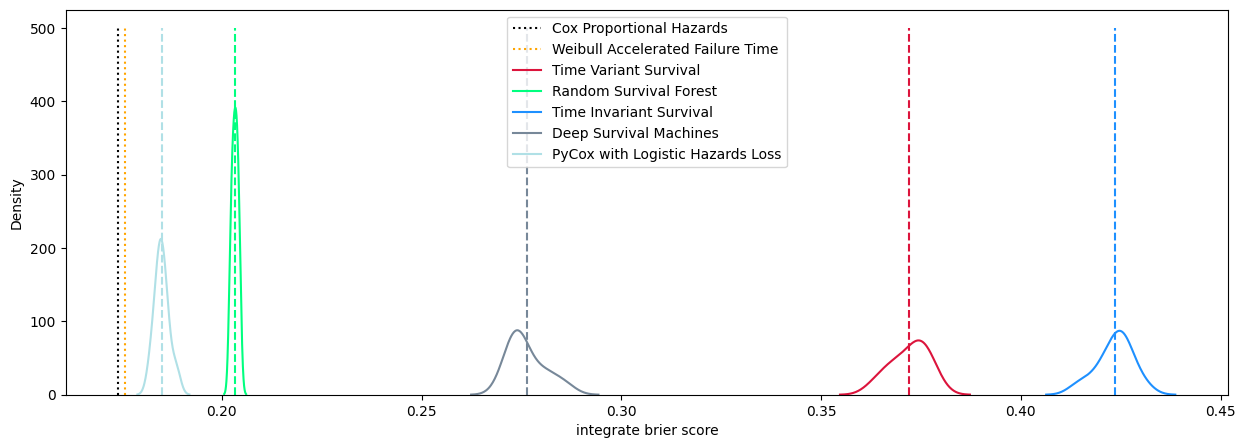

In [13]:
import seaborn as sns

criteria = 'ibs'
ymax = 500

fig , ax = plt.subplots(figsize = (15 , 5))

plt.vlines(np.mean(np.array(dict_fits['cph'][criteria])) , ymin = 0 , ymax = ymax , color = 'black' , ls=':' ,
           label = 'Cox Proportional Hazards')
plt.vlines(np.mean(np.array(dict_fits['aft'][criteria])) , ymin = 0 , ymax = ymax , color = 'orange' , ls=':' ,
           label = 'Weibull Accelerated Failure Time')

sns.kdeplot(np.array(dict_fits['tvs'][criteria]) , label = 'Time Variant Survival' , color = 'crimson');
plt.vlines(np.mean(np.array(dict_fits['tvs'][criteria])) , ymin = 0 , ymax = ymax , ls = '--' , color = 'crimson')

sns.kdeplot(np.array(dict_fits['rsf'][criteria]) , label = 'Random Survival Forest' , color = 'springgreen');
plt.vlines(np.mean(np.array(dict_fits['rsf'][criteria])) , ymin = 0 , ymax = ymax , ls = '--' , color = 'springgreen')

sns.kdeplot(np.array(dict_fits['tis'][criteria]) , label = 'Time Invariant Survival' , color = 'dodgerblue');
plt.vlines(np.mean(np.array(dict_fits['tis'][criteria])) , ymin = 0 , ymax = ymax , ls = '--' , color = 'dodgerblue')

sns.kdeplot(np.array(dict_fits['dsm'][criteria]) , label = 'Deep Survival Machines' , color = 'lightslategray');
plt.vlines(np.mean(np.array(dict_fits['dsm'][criteria])) , ymin = 0 , ymax = ymax , ls = '--' , color = 'lightslategray')

sns.kdeplot(np.array(dict_fits['pyc'][criteria]) , label = 'PyCox with Logistic Hazards Loss', color = 'powderblue');
plt.vlines(np.mean(np.array(dict_fits['pyc'][criteria])) , ymin = 0 , ymax = ymax , ls = '--' , color = 'powderblue')
plt.legend(loc='upper center');
plt.xlabel('integrate brier score')

# Save the plot as an SVG file
plt.savefig('ibs_dist_plot.pdf', format='pdf')

plt.show()

In [ ]:
# eval_dict_prop = {'tvs': {'cindex': [0.7042775602478653, 0.7263603822868985, 0.7107695127725984, 0.7259683192716793, 0.7203979694190848, 0.7180608665101809, 0.7147665188368457, 0.708452776773576, 0.7119253349083744, 0.711920243180904], 'ibs': [0.3818148929641995, 0.3823403610469341, 0.37954591969646856, 0.3811284354046998, 0.3744284469015903, 0.36816643970925084, 0.37915719936915715, 0.38557467362288184, 0.3850987495997086, 0.389852010001371]}, 'tis': {'cindex': [0.6868459869848156, 0.6770195227765726, 0.6796399132321042, 0.6839349240780911, 0.6797483731019522, 0.6812798264642083, 0.6926594360086767, 0.6850065075921908, 0.6775965292841648, 0.6818785249457701], 'ibs': [0.33068832895734057, 0.32626747986886856, 0.3243223441211255, 0.32718150706402704, 0.32377040210947355, 0.32847106135422405, 0.32583011291301883, 0.32451522903392993, 0.3193583186730061, 0.32984878944920193]}}
# eval_dict_other = {'tvs': {'cindex': [0.6906520975371314, 0.6866245411080617, 0.6882131600788199, 0.7161616521637296, 0.7065841127919469, 0.7175669689455542, 0.6758148036884474, 0.7157033966913955, 0.7032693982087302, 0.6895675595859407], 'ibs': [0.37877058260428176, 0.37809304652892256, 0.3789795747918701, 0.37651122921303165, 0.36940151563458723, 0.36767668188501285, 0.37576180776628687, 0.3768074450583407, 0.37109503685735595, 0.3732709676447046]}, 'tis': {'cindex': [0.6798091106290672, 0.6843817787418656, 0.6831626898047722, 0.6734880694143167, 0.6770802603036876, 0.6752190889370933, 0.6710889370932754, 0.6764251626898048, 0.6807809110629067, 0.6834316702819957], 'ibs': [0.3194578267505521, 0.316205924091295, 0.32555695503654486, 0.33670516454352306, 0.3240213641646544, 0.32531470992847, 0.32133167543798563, 0.3292695064731646, 0.32315408442246774, 0.3215501678832269]}, 'cph': {'cindex': [0.6896521712642028, 0.6896521712642028, 0.6896521712642028, 0.6896521712642028, 0.6896521712642028, 0.6896521712642028, 0.6896521712642028, 0.6896521712642028, 0.6896521712642028, 0.6896521712642028], 'ibs': [0.1571099954707319, 0.1571099954707319, 0.1571099954707319, 0.1571099954707319, 0.1571099954707319, 0.1571099954707319, 0.1571099954707319, 0.1571099954707319, 0.1571099954707319, 0.1571099954707319]}, 'aft': {'cindex': [0.6857313193818892, 0.6857313193818892, 0.6857313193818892, 0.6857313193818892, 0.6857313193818892, 0.6857313193818892, 0.6857313193818892, 0.6857313193818892, 0.6857313193818892, 0.6857313193818892], 'ibs': [0.16555692700083421, 0.16555692700083421, 0.16555692700083421, 0.16555692700083421, 0.16555692700083421, 0.16555692700083421, 0.16555692700083421, 0.16555692700083421, 0.16555692700083421, 0.16555692700083421]}, 'rsf': {'cindex': [0.701266770236339, 0.701266770236339, 0.701266770236339, 0.701266770236339, 0.701266770236339, 0.701266770236339, 0.701266770236339, 0.701266770236339, 0.701266770236339, 0.701266770236339], 'ibs': [0.18046974107118963, 0.1804697410711896, 0.18046974107118963, 0.18046974107118963, 0.1804697410711896, 0.18046974107118963, 0.18046974107118963, 0.1804697410711896, 0.18046974107118963, 0.1804697410711896]}, 'pyc': {'cindex': [0.5895159640900447, 0.5902992641331262, 0.5930234076162875, 0.5738847765636627, 0.5951209110649834, 0.5804209802564873, 0.5895159640900447, 0.5944681610290822, 0.6049991949416224, 0.5629055209598036], 'ibs': [0.16613944753838378, 0.16231792529024683, 0.16342578188078558, 0.16332419710441212, 0.16653640214210538, 0.16332565412833783, 0.16439865628626588, 0.16438358230156927, 0.16390380624773448, 0.1648095849788064]}, 'dsm': {'cindex': [0.6606831246709052, 0.6523975508818654, 0.6555525093887213, 0.6409570185859693, 0.6566012611130694, 0.6504480041079735, 0.6383764801107064, 0.643367842051898, 0.6570103178022342, 0.6610399613571979], 'ibs': [0.2364237196775679, 0.24283150338207304, 0.23775457949315928, 0.24406428358609658, 0.23832675873815326, 0.24076795996416445, 0.24272261904833506, 0.24844747374558612, 0.23845052964534713, 0.23416780529775014]}}
# eval_dict_rsf = {'rsf': {'cindex': [0.6992867617941052, 0.6919411480567631, 0.6985513300869898, 0.7053051171251148, 0.7063147038473088, 0.6942518831838536, 0.7054965904689792, 0.6992127834567031, 0.6992998167948232, 0.699151860120019], 'ibs': [0.17744858624036697, 0.18080741663472621, 0.17938018525024158, 0.17960778948899414, 0.17950639376209135, 0.18095338678013267, 0.17901612756679883, 0.180478999007675, 0.18125021979264563, 0.17846230371548924]}}
# tis_fits = {'tis': {'cindex': [0.6760248447204968, 0.6838533674339301, 0.6808671294604799, 0.6675825112653757, 0.6877213494093289, 0.6858458165875045, 0.6868347338935574, 0.6856460845207648, 0.6801802460114481, 0.6722689075630253], 'ibs': [0.41549088745822044, 0.40532337930433543, 0.4086049023128192, 0.4082577289249966, 0.41019150728290504, 0.4057090328204202, 0.4059675848218976, 0.40501888890218, 0.4040171396210184, 0.4003400959928267]}}
# tis_fits = {
#     'tis': {'cindex': [0.6798246255023749, 0.6889343563512361, 0.6804676653270003, 0.6870783095847034, 0.6857142857142857, 0.6719863597612958, 0.6777103885032274, 0.6735988308366825, 0.6708220679576178, 0.67307757885763], 'ibs': [0.40238379804448215, 0.39795193481341434, 0.39776457295927886, 0.40475383344425336, 0.4023690795140116, 0.4086251473723642, 0.39936740668498244, 0.39705766315082686, 0.4037936479455543, 0.4004615863232152]}
#     }
# tis_fits = {
#     'tis': {'cindex': [0.6893484350261844, 0.6914431859700402, 0.6925538911216661, 0.6789039093898429, 0.6883595177201315, 0.6869467787114846, 0.6894263792473511, 0.6875654609669954, 0.6878772378516624, 0.6857971014492754], 'ibs': [0.3935339562028297, 0.3973846117792459, 0.3939356387386795, 0.3917035901560046, 0.3926268318062733, 0.3934975872764461, 0.4021520870169422, 0.41153614061674276, 0.39017323363064066, 0.39892593031927515]}
# }


# trad_fits = {'cph': {'cindex': [0.6971421592574499, 0.6971421592574499, 0.6971421592574499], 'ibs': [0.1623865678248454, 0.1623865678248454, 0.1623865678248454]}, 'aft': {'cindex': [0.6989008304836346, 0.6989008304836346, 0.6989008304836346], 'ibs': [0.16671168932453048, 0.16671168932453048, 0.16671168932453048]}}

# tis_fits = {
#     'tis': {'cindex': [0.6853391791499208, 0.6930020703933747, 0.6884910485933504, 0.6875411033978809, 0.6827913774205334, 0.6841846303738887, 0.6852271343319937, 0.6922177566678845, 0.6788844233345512, 0.6781293386919985], 'ibs': [0.3937163548782007, 0.38839365389533465, 0.39576353214337795, 0.3981800983915627, 0.40884326044957114, 0.39586229138398155, 0.40134845188727086, 0.4021846685179, 0.4067051020790429, 0.4040382088592244]}
# }

# nn_fits = {
#     'tvs': {'cindex': [0.7372124221389725, 0.7397618663267408, 0.723669195700457, 0.735854202964703, 0.7449275523665856, 0.7326256491898, 0.7301597020824172, 0.7109609400657957, 0.7135771819178722, 0.7367058731846343], 'ibs': [0.4170030948508229, 0.4193348334170594, 0.422823417571111, 0.41925211584249644, 0.4119093647289647, 0.41962469087893167, 0.4161600981256204, 0.41835297261807214, 0.41505058818845236, 0.4043290069709479]}, 
#     'pyc': {'cindex': [0.6033756717147044, 0.6211968734733757, 0.5952222765021984, 0.5794577430385931, 0.6123106985832927, 0.6009281875915975, 0.5963361016121153, 0.6062335124572545, 0.6278993649242794, 0.591514411333659], 'ibs': [0.1692477340906124, 0.17276722138917652, 0.16987988436596624, 0.1701011648712293, 0.17285600790112235, 0.17176046672867581, 0.17077334958221496, 0.17181230315780424, 0.17197536323985183, 0.16721961187005857]}, 
#     'dsm': {'cindex': [0.64285784074255, 0.6525158768930142, 0.6494870542256962, 0.6460723009281876, 0.6397361993160723, 0.6552320468978994, 0.6501758671226184, 0.6403126526624329, 0.646790425012213, 0.6425793844650708], 'ibs': [0.27230548944336647, 0.2666764526021103, 0.27083855573641097, 0.27451816390819006, 0.2781181829968994, 0.2678610160163292, 0.2705338146773593, 0.27322937612510195, 0.2719555817425159, 0.2721651101597905]}
#     }

# rsf_fits = {'rsf': {'cindex': [0.7038837322911577, 0.6974792379091354, 0.6975085490962384, 0.703590620420127, 0.6994772838299951, 0.7050464093795799, 0.703561309233024, 0.6943380556912555, 0.7023497801660967, 0.7038788470933073], 'ibs': [0.1946815424335125, 0.19476557898733865, 0.19793585201945518, 0.19738071007559274, 0.19610514807730386, 0.19722367105612873, 0.19635179567649994, 0.19671100740666195, 0.1968018048674239, 0.19602441544389138]}}